In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
import math
import copy
warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('ggplot')
mpl.rcParams['axes.unicode_minus']=False
# 폰트 설정
mpl.rc('font', family='Malgun Gothic')
# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

In [2]:
rental_data=pd.read_csv('C:/Users/user/Desktop/서울시청/데이터/독립변수/최종독립변수(변환후).csv',encoding='cp949')

In [3]:
rental_data.columns

Index(['대여소번호', 'subway', 'park', '상업지역', 'weighted_LEN_mean', 'mean_width',
       '주거', 'school', 'sports', 'adult', 'study', 'market', 'game', 'house',
       'culture', 'hell', 'parking', 'bike', 'bus_dis', 'bus_all', 'sub_all',
       '건축면적', '건폐율', '공시지가', '지하층수', '용적율', '높이', '연면적', '지상층수', '대지면적', '인구',
       'starbucks', 'PB', 'count'],
      dtype='object')

In [4]:
rental_data['starbucks']=rental_data['starbucks'].astype('category')
rental_data['PB']=rental_data['PB'].astype('category')
rental_data['상업지역']=rental_data['상업지역'].astype('category')

In [5]:
rental_data=rental_data[[ 'subway',  '상업지역', 'weighted_LEN_mean', 'mean_width',
       '주거', 'school', 'sports', 'study', 'market', 'game', 
       'culture',  'parking', 'bike','bus_all', 'sub_all',
         '용적율', '지상층수', '대지면적', '인구','starbucks','PB','count']]

## RMSE SCORE

In [6]:
from sklearn.metrics import make_scorer
def rmsle(predict,actual):
    
    predict=np.array(predict)
    actual=np.array(actual)
    log_predict=np.log(predict+1)
    log_actual=np.log(actual+1)
    difference=log_predict-log_actual
    diff=np.square(difference)
    mean_diff=diff.mean()
    score=np.sqrt(mean_diff)
    
    return score
rmsle_scorer=make_scorer(rmsle)

# 랜덤포레스트

In [12]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
RandomForestRegressor()

RandomForestRegressor()

#### 7:3 train, test 데이터 셋 분할

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(rental_data, test_size=0.3, random_state=0)
train.shape, test.shape

((1059, 22), (454, 22))

In [14]:
x_train=train.drop('count',axis=1)
y_train=train['count']
x_test=test.drop('count',axis=1)
y_test=test['count']

In [15]:
train.head()

,subway,상업지역,weighted_LEN_mean,mean_width,주거,school,sports,study,market,game,...,bike,bus_all,sub_all,용적율,지상층수,대지면적,인구,starbucks,PB,count
411,20.578417,1.0,0.866368,4.982639,19119.356323,21.256279,16.456202,4.699234,4.650070,4.258190,...,18.136247,200.129958,14.279255,43.887698,56.76,9.067002,7.215435,3.0,1.0,7.505492
546,21.632114,0.0,1.646499,2.348655,9373.022461,9.434771,19.663211,4.537990,5.525057,5.025274,...,27.554452,72.117959,13.619645,29.692592,50.03,10.010659,2.994676,1.0,2.0,6.363028
249,12.626818,0.0,0.000000,4.099226,14141.651733,23.708276,15.891333,5.172726,5.531548,5.803574,...,28.255215,0.000000,12.504168,47.020208,76.00,9.302281,8.480369,3.0,2.0,7.393263
1124,36.280024,0.0,1.462671,5.483217,27156.714966,14.578958,21.973091,3.911496,4.506303,4.925080,...,36.584963,180.330253,13.876245,32.267476,22.08,8.069493,6.626394,0.0,1.0,5.874931
871,19.648908,0.0,0.856187,4.283918,31383.638306,21.125381,16.811909,3.554890,3.111501,4.268334,...,18.828914,66.783231,13.915560,44.331930,108.93,9.242500,5.717906,8.0,4.0,5.993961


## 1차 파라미터 조정

### K-Fold validation
* 셔플 5회

In [16]:
num_epoch = 1000 # 1000번
hyperparameters_list = [] # 조정된 파라미터 저장
for epoch in range(num_epoch):
    n_estimators = np.random.randint(low=100, high=1000) # 100 ~ 1000개의 결정 트리
    max_depth = np.random.randint(low=10, high=100)  # 최대 깊이
    max_feature = np.random.randint(low=6,high=21)  # 최대 속성 수
    min_samples_leaf=np.random.randint(low=1,high=10) # 리프노드 최소 샘플 수
    min_samples_split=np.random.randint(low=2,high=10) # 분할 최소 샘플 수
    model = RandomForestRegressor(n_estimators= n_estimators,
                              max_depth=max_depth,
                                  max_features=max_feature,
                                  min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split,
                           random_state=0,
                           n_jobs=-1)
    k_fold = KFold(5, shuffle=True, random_state=0)
    score = cross_val_score(model, x_train, y_train, cv=k_fold, scoring=rmsle_scorer).mean()
    model.fit(x_train,y_train)
    hyperparameters = {'epoch': epoch,'score': score,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'max_features': max_feature,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                      'model_score':model.score(x_test,y_test)}
    
    hyperparameters_list.append(hyperparameters)
    success=0
    fail=0
    pred=model.predict(x_test)
    t=list(y_test)
    for p in range(len(pred)):
        if abs(pred[p]-t[p])<=0.4:
            success+=1
        else:
            fail+=1
    acc=success/(success+fail)*100
    print(f"{epoch:2} n_estimators = {n_estimators}, max_depth = {max_depth},max_features = {max_feature}, min_samples_leaf = {min_samples_leaf}, min_samples_split = {min_samples_split}, Score = {score:.5f},model_score = {model.score(x_test,y_test):.7f},accuary={acc:.7f}")

hyperparameters_df = pd.DataFrame.from_dict(hyperparameters_list)
# (RMSE는 score가 낮을 수록 더 정확도가 높다고 가정합니다)

hyperparameters_df = hyperparameters_df.sort_values(by="score")
print(hyperparameters_df.shape)
hyperparameters_df.head(10)

 0 n_estimators = 262, max_depth = 42,max_features = 17, min_samples_leaf = 2, min_samples_split = 2, Score = 0.08263,model_score = 0.3873874,accuary=48.2378855
 1 n_estimators = 416, max_depth = 81,max_features = 11, min_samples_leaf = 6, min_samples_split = 6, Score = 0.08265,model_score = 0.3807723,accuary=48.2378855
 2 n_estimators = 837, max_depth = 18,max_features = 9, min_samples_leaf = 4, min_samples_split = 5, Score = 0.08234,model_score = 0.3810705,accuary=49.3392070
 3 n_estimators = 655, max_depth = 57,max_features = 8, min_samples_leaf = 9, min_samples_split = 8, Score = 0.08303,model_score = 0.3705848,accuary=49.3392070
 4 n_estimators = 749, max_depth = 48,max_features = 11, min_samples_leaf = 4, min_samples_split = 7, Score = 0.08240,model_score = 0.3822335,accuary=50.0000000
 5 n_estimators = 465, max_depth = 88,max_features = 11, min_samples_leaf = 4, min_samples_split = 4, Score = 0.08248,model_score = 0.3815995,accuary=50.4405286
 6 n_estimators = 348, max_depth = 5

51 n_estimators = 615, max_depth = 56,max_features = 12, min_samples_leaf = 4, min_samples_split = 2, Score = 0.08240,model_score = 0.3807578,accuary=48.2378855
52 n_estimators = 909, max_depth = 16,max_features = 11, min_samples_leaf = 2, min_samples_split = 9, Score = 0.08225,model_score = 0.3782286,accuary=49.1189427
53 n_estimators = 631, max_depth = 11,max_features = 16, min_samples_leaf = 9, min_samples_split = 3, Score = 0.08304,model_score = 0.3746645,accuary=48.6784141
54 n_estimators = 838, max_depth = 48,max_features = 12, min_samples_leaf = 4, min_samples_split = 2, Score = 0.08245,model_score = 0.3800027,accuary=49.3392070
55 n_estimators = 388, max_depth = 42,max_features = 13, min_samples_leaf = 9, min_samples_split = 7, Score = 0.08286,model_score = 0.3724460,accuary=48.2378855
56 n_estimators = 121, max_depth = 73,max_features = 17, min_samples_leaf = 7, min_samples_split = 4, Score = 0.08280,model_score = 0.3698457,accuary=49.3392070
57 n_estimators = 230, max_depth =

102 n_estimators = 444, max_depth = 59,max_features = 11, min_samples_leaf = 5, min_samples_split = 4, Score = 0.08259,model_score = 0.3816363,accuary=49.1189427
103 n_estimators = 801, max_depth = 16,max_features = 14, min_samples_leaf = 7, min_samples_split = 5, Score = 0.08266,model_score = 0.3791257,accuary=48.6784141
104 n_estimators = 158, max_depth = 84,max_features = 12, min_samples_leaf = 5, min_samples_split = 3, Score = 0.08266,model_score = 0.3781392,accuary=48.2378855
105 n_estimators = 714, max_depth = 75,max_features = 9, min_samples_leaf = 5, min_samples_split = 8, Score = 0.08252,model_score = 0.3801811,accuary=48.6784141
106 n_estimators = 391, max_depth = 94,max_features = 13, min_samples_leaf = 5, min_samples_split = 2, Score = 0.08244,model_score = 0.3846382,accuary=49.1189427
107 n_estimators = 776, max_depth = 70,max_features = 6, min_samples_leaf = 9, min_samples_split = 8, Score = 0.08328,model_score = 0.3646649,accuary=49.3392070
108 n_estimators = 401, max_de

153 n_estimators = 116, max_depth = 34,max_features = 14, min_samples_leaf = 3, min_samples_split = 3, Score = 0.08262,model_score = 0.3801405,accuary=49.3392070
154 n_estimators = 218, max_depth = 30,max_features = 9, min_samples_leaf = 6, min_samples_split = 3, Score = 0.08271,model_score = 0.3808335,accuary=49.1189427
155 n_estimators = 799, max_depth = 76,max_features = 11, min_samples_leaf = 4, min_samples_split = 3, Score = 0.08240,model_score = 0.3815282,accuary=48.8986784
156 n_estimators = 255, max_depth = 38,max_features = 11, min_samples_leaf = 8, min_samples_split = 8, Score = 0.08305,model_score = 0.3774681,accuary=49.1189427
157 n_estimators = 785, max_depth = 47,max_features = 20, min_samples_leaf = 8, min_samples_split = 4, Score = 0.08295,model_score = 0.3734893,accuary=48.4581498
158 n_estimators = 780, max_depth = 94,max_features = 13, min_samples_leaf = 8, min_samples_split = 4, Score = 0.08274,model_score = 0.3766705,accuary=48.8986784
159 n_estimators = 836, max_d

204 n_estimators = 268, max_depth = 35,max_features = 10, min_samples_leaf = 1, min_samples_split = 4, Score = 0.08196,model_score = 0.3897067,accuary=50.0000000
205 n_estimators = 857, max_depth = 70,max_features = 11, min_samples_leaf = 8, min_samples_split = 9, Score = 0.08281,model_score = 0.3775995,accuary=48.0176211
206 n_estimators = 753, max_depth = 56,max_features = 10, min_samples_leaf = 6, min_samples_split = 4, Score = 0.08266,model_score = 0.3782630,accuary=49.1189427
207 n_estimators = 871, max_depth = 42,max_features = 20, min_samples_leaf = 7, min_samples_split = 2, Score = 0.08278,model_score = 0.3752005,accuary=48.8986784
208 n_estimators = 842, max_depth = 40,max_features = 11, min_samples_leaf = 5, min_samples_split = 2, Score = 0.08251,model_score = 0.3817616,accuary=49.7797357
209 n_estimators = 629, max_depth = 99,max_features = 11, min_samples_leaf = 7, min_samples_split = 2, Score = 0.08278,model_score = 0.3785448,accuary=48.8986784
210 n_estimators = 367, max_

255 n_estimators = 378, max_depth = 46,max_features = 7, min_samples_leaf = 5, min_samples_split = 3, Score = 0.08270,model_score = 0.3739225,accuary=48.4581498
256 n_estimators = 615, max_depth = 48,max_features = 18, min_samples_leaf = 5, min_samples_split = 5, Score = 0.08252,model_score = 0.3779846,accuary=49.5594714
257 n_estimators = 331, max_depth = 69,max_features = 17, min_samples_leaf = 4, min_samples_split = 4, Score = 0.08252,model_score = 0.3794968,accuary=48.8986784
258 n_estimators = 226, max_depth = 95,max_features = 19, min_samples_leaf = 6, min_samples_split = 2, Score = 0.08267,model_score = 0.3726368,accuary=48.4581498
259 n_estimators = 549, max_depth = 25,max_features = 20, min_samples_leaf = 6, min_samples_split = 7, Score = 0.08263,model_score = 0.3744894,accuary=48.6784141
260 n_estimators = 852, max_depth = 28,max_features = 17, min_samples_leaf = 5, min_samples_split = 7, Score = 0.08264,model_score = 0.3812826,accuary=49.3392070
261 n_estimators = 331, max_d

306 n_estimators = 221, max_depth = 41,max_features = 11, min_samples_leaf = 6, min_samples_split = 3, Score = 0.08263,model_score = 0.3807607,accuary=49.3392070
307 n_estimators = 386, max_depth = 36,max_features = 9, min_samples_leaf = 6, min_samples_split = 8, Score = 0.08271,model_score = 0.3813452,accuary=49.5594714
308 n_estimators = 808, max_depth = 83,max_features = 15, min_samples_leaf = 7, min_samples_split = 7, Score = 0.08269,model_score = 0.3785433,accuary=48.2378855
309 n_estimators = 977, max_depth = 69,max_features = 13, min_samples_leaf = 1, min_samples_split = 2, Score = 0.08211,model_score = 0.3798406,accuary=49.7797357
310 n_estimators = 261, max_depth = 78,max_features = 15, min_samples_leaf = 4, min_samples_split = 4, Score = 0.08249,model_score = 0.3776653,accuary=48.0176211
311 n_estimators = 669, max_depth = 74,max_features = 13, min_samples_leaf = 3, min_samples_split = 3, Score = 0.08224,model_score = 0.3843561,accuary=48.4581498
312 n_estimators = 257, max_d

357 n_estimators = 626, max_depth = 37,max_features = 18, min_samples_leaf = 1, min_samples_split = 8, Score = 0.08215,model_score = 0.3756581,accuary=50.0000000
358 n_estimators = 227, max_depth = 70,max_features = 14, min_samples_leaf = 5, min_samples_split = 6, Score = 0.08245,model_score = 0.3835914,accuary=49.5594714
359 n_estimators = 567, max_depth = 92,max_features = 15, min_samples_leaf = 4, min_samples_split = 5, Score = 0.08241,model_score = 0.3797982,accuary=49.3392070
360 n_estimators = 805, max_depth = 79,max_features = 14, min_samples_leaf = 4, min_samples_split = 3, Score = 0.08255,model_score = 0.3812020,accuary=49.7797357
361 n_estimators = 104, max_depth = 22,max_features = 19, min_samples_leaf = 3, min_samples_split = 7, Score = 0.08236,model_score = 0.3706173,accuary=51.7621145
362 n_estimators = 611, max_depth = 43,max_features = 8, min_samples_leaf = 7, min_samples_split = 4, Score = 0.08280,model_score = 0.3750258,accuary=49.5594714
363 n_estimators = 160, max_d

408 n_estimators = 878, max_depth = 12,max_features = 8, min_samples_leaf = 5, min_samples_split = 9, Score = 0.08255,model_score = 0.3822765,accuary=48.8986784
409 n_estimators = 783, max_depth = 19,max_features = 20, min_samples_leaf = 9, min_samples_split = 5, Score = 0.08299,model_score = 0.3722250,accuary=48.6784141
410 n_estimators = 102, max_depth = 97,max_features = 17, min_samples_leaf = 1, min_samples_split = 2, Score = 0.08256,model_score = 0.3741647,accuary=49.7797357
411 n_estimators = 897, max_depth = 35,max_features = 19, min_samples_leaf = 8, min_samples_split = 9, Score = 0.08293,model_score = 0.3740819,accuary=49.1189427
412 n_estimators = 197, max_depth = 85,max_features = 11, min_samples_leaf = 4, min_samples_split = 9, Score = 0.08254,model_score = 0.3823267,accuary=48.2378855
413 n_estimators = 664, max_depth = 35,max_features = 19, min_samples_leaf = 3, min_samples_split = 2, Score = 0.08250,model_score = 0.3774973,accuary=48.4581498
414 n_estimators = 790, max_d

459 n_estimators = 559, max_depth = 91,max_features = 15, min_samples_leaf = 8, min_samples_split = 8, Score = 0.08281,model_score = 0.3756403,accuary=48.8986784
460 n_estimators = 222, max_depth = 91,max_features = 11, min_samples_leaf = 7, min_samples_split = 8, Score = 0.08302,model_score = 0.3770690,accuary=48.2378855
461 n_estimators = 134, max_depth = 71,max_features = 10, min_samples_leaf = 9, min_samples_split = 4, Score = 0.08314,model_score = 0.3722262,accuary=49.5594714
462 n_estimators = 452, max_depth = 83,max_features = 17, min_samples_leaf = 4, min_samples_split = 8, Score = 0.08253,model_score = 0.3786439,accuary=48.4581498
463 n_estimators = 549, max_depth = 58,max_features = 7, min_samples_leaf = 8, min_samples_split = 5, Score = 0.08294,model_score = 0.3692898,accuary=49.1189427
464 n_estimators = 995, max_depth = 36,max_features = 14, min_samples_leaf = 4, min_samples_split = 7, Score = 0.08251,model_score = 0.3823407,accuary=49.5594714
465 n_estimators = 589, max_d

510 n_estimators = 943, max_depth = 37,max_features = 6, min_samples_leaf = 3, min_samples_split = 7, Score = 0.08246,model_score = 0.3806521,accuary=50.0000000
511 n_estimators = 210, max_depth = 97,max_features = 18, min_samples_leaf = 5, min_samples_split = 8, Score = 0.08275,model_score = 0.3760489,accuary=48.8986784
512 n_estimators = 583, max_depth = 22,max_features = 15, min_samples_leaf = 7, min_samples_split = 4, Score = 0.08273,model_score = 0.3786904,accuary=48.8986784
513 n_estimators = 808, max_depth = 29,max_features = 20, min_samples_leaf = 7, min_samples_split = 8, Score = 0.08276,model_score = 0.3741491,accuary=48.8986784
514 n_estimators = 496, max_depth = 13,max_features = 10, min_samples_leaf = 2, min_samples_split = 6, Score = 0.08245,model_score = 0.3829288,accuary=49.1189427
515 n_estimators = 199, max_depth = 32,max_features = 9, min_samples_leaf = 6, min_samples_split = 8, Score = 0.08271,model_score = 0.3796166,accuary=49.7797357
516 n_estimators = 332, max_de

561 n_estimators = 262, max_depth = 92,max_features = 11, min_samples_leaf = 1, min_samples_split = 2, Score = 0.08203,model_score = 0.3829790,accuary=49.7797357
562 n_estimators = 339, max_depth = 21,max_features = 7, min_samples_leaf = 4, min_samples_split = 4, Score = 0.08236,model_score = 0.3781512,accuary=49.3392070
563 n_estimators = 647, max_depth = 15,max_features = 8, min_samples_leaf = 8, min_samples_split = 2, Score = 0.08298,model_score = 0.3714023,accuary=48.8986784
564 n_estimators = 393, max_depth = 40,max_features = 9, min_samples_leaf = 5, min_samples_split = 6, Score = 0.08258,model_score = 0.3783455,accuary=48.2378855
565 n_estimators = 300, max_depth = 76,max_features = 17, min_samples_leaf = 1, min_samples_split = 4, Score = 0.08248,model_score = 0.3806407,accuary=49.7797357
566 n_estimators = 211, max_depth = 48,max_features = 14, min_samples_leaf = 4, min_samples_split = 8, Score = 0.08254,model_score = 0.3888451,accuary=51.1013216
567 n_estimators = 859, max_dep

612 n_estimators = 931, max_depth = 69,max_features = 16, min_samples_leaf = 8, min_samples_split = 2, Score = 0.08279,model_score = 0.3751825,accuary=48.6784141
613 n_estimators = 438, max_depth = 78,max_features = 17, min_samples_leaf = 4, min_samples_split = 3, Score = 0.08252,model_score = 0.3785831,accuary=48.2378855
614 n_estimators = 277, max_depth = 91,max_features = 17, min_samples_leaf = 8, min_samples_split = 3, Score = 0.08303,model_score = 0.3730657,accuary=48.4581498
615 n_estimators = 397, max_depth = 86,max_features = 17, min_samples_leaf = 5, min_samples_split = 9, Score = 0.08261,model_score = 0.3822699,accuary=49.7797357
616 n_estimators = 483, max_depth = 40,max_features = 9, min_samples_leaf = 7, min_samples_split = 2, Score = 0.08280,model_score = 0.3775535,accuary=49.3392070
617 n_estimators = 507, max_depth = 45,max_features = 12, min_samples_leaf = 9, min_samples_split = 8, Score = 0.08290,model_score = 0.3734433,accuary=48.4581498
618 n_estimators = 260, max_d

663 n_estimators = 372, max_depth = 33,max_features = 12, min_samples_leaf = 7, min_samples_split = 3, Score = 0.08274,model_score = 0.3786563,accuary=48.6784141
664 n_estimators = 121, max_depth = 10,max_features = 19, min_samples_leaf = 7, min_samples_split = 2, Score = 0.08288,model_score = 0.3653777,accuary=48.8986784
665 n_estimators = 989, max_depth = 54,max_features = 12, min_samples_leaf = 2, min_samples_split = 5, Score = 0.08220,model_score = 0.3844004,accuary=49.7797357
666 n_estimators = 888, max_depth = 91,max_features = 12, min_samples_leaf = 3, min_samples_split = 2, Score = 0.08243,model_score = 0.3841357,accuary=48.8986784
667 n_estimators = 790, max_depth = 12,max_features = 14, min_samples_leaf = 4, min_samples_split = 2, Score = 0.08256,model_score = 0.3808703,accuary=50.4405286
668 n_estimators = 917, max_depth = 55,max_features = 17, min_samples_leaf = 5, min_samples_split = 8, Score = 0.08263,model_score = 0.3816590,accuary=49.3392070
669 n_estimators = 385, max_

714 n_estimators = 842, max_depth = 73,max_features = 17, min_samples_leaf = 3, min_samples_split = 4, Score = 0.08226,model_score = 0.3791569,accuary=48.4581498
715 n_estimators = 982, max_depth = 37,max_features = 14, min_samples_leaf = 6, min_samples_split = 8, Score = 0.08258,model_score = 0.3825877,accuary=49.5594714
716 n_estimators = 528, max_depth = 42,max_features = 7, min_samples_leaf = 3, min_samples_split = 6, Score = 0.08226,model_score = 0.3816289,accuary=49.5594714
717 n_estimators = 112, max_depth = 36,max_features = 6, min_samples_leaf = 8, min_samples_split = 9, Score = 0.08337,model_score = 0.3682605,accuary=49.5594714
718 n_estimators = 468, max_depth = 38,max_features = 8, min_samples_leaf = 9, min_samples_split = 3, Score = 0.08306,model_score = 0.3722808,accuary=49.3392070
719 n_estimators = 981, max_depth = 24,max_features = 18, min_samples_leaf = 9, min_samples_split = 8, Score = 0.08292,model_score = 0.3719271,accuary=48.8986784
720 n_estimators = 808, max_dep

765 n_estimators = 371, max_depth = 73,max_features = 7, min_samples_leaf = 9, min_samples_split = 6, Score = 0.08319,model_score = 0.3679706,accuary=48.6784141
766 n_estimators = 250, max_depth = 97,max_features = 16, min_samples_leaf = 4, min_samples_split = 5, Score = 0.08255,model_score = 0.3768330,accuary=48.8986784
767 n_estimators = 204, max_depth = 13,max_features = 9, min_samples_leaf = 5, min_samples_split = 7, Score = 0.08269,model_score = 0.3770128,accuary=49.5594714
768 n_estimators = 293, max_depth = 72,max_features = 11, min_samples_leaf = 6, min_samples_split = 8, Score = 0.08260,model_score = 0.3843872,accuary=49.1189427
769 n_estimators = 239, max_depth = 52,max_features = 17, min_samples_leaf = 5, min_samples_split = 4, Score = 0.08273,model_score = 0.3811721,accuary=50.8810573
770 n_estimators = 872, max_depth = 34,max_features = 16, min_samples_leaf = 8, min_samples_split = 2, Score = 0.08279,model_score = 0.3752517,accuary=48.6784141
771 n_estimators = 761, max_de

816 n_estimators = 291, max_depth = 52,max_features = 11, min_samples_leaf = 9, min_samples_split = 8, Score = 0.08300,model_score = 0.3725029,accuary=48.2378855
817 n_estimators = 631, max_depth = 89,max_features = 18, min_samples_leaf = 8, min_samples_split = 6, Score = 0.08277,model_score = 0.3741378,accuary=48.6784141
818 n_estimators = 896, max_depth = 90,max_features = 11, min_samples_leaf = 3, min_samples_split = 3, Score = 0.08230,model_score = 0.3855642,accuary=49.5594714
819 n_estimators = 717, max_depth = 38,max_features = 20, min_samples_leaf = 4, min_samples_split = 8, Score = 0.08252,model_score = 0.3776070,accuary=49.1189427
820 n_estimators = 595, max_depth = 28,max_features = 11, min_samples_leaf = 1, min_samples_split = 6, Score = 0.08217,model_score = 0.3778806,accuary=49.7797357
821 n_estimators = 982, max_depth = 25,max_features = 6, min_samples_leaf = 2, min_samples_split = 3, Score = 0.08222,model_score = 0.3849524,accuary=50.0000000
822 n_estimators = 968, max_d

867 n_estimators = 535, max_depth = 13,max_features = 20, min_samples_leaf = 7, min_samples_split = 2, Score = 0.08268,model_score = 0.3751386,accuary=48.8986784
868 n_estimators = 589, max_depth = 97,max_features = 15, min_samples_leaf = 9, min_samples_split = 4, Score = 0.08298,model_score = 0.3754779,accuary=48.8986784
869 n_estimators = 247, max_depth = 13,max_features = 19, min_samples_leaf = 7, min_samples_split = 8, Score = 0.08275,model_score = 0.3741952,accuary=49.1189427
870 n_estimators = 955, max_depth = 98,max_features = 13, min_samples_leaf = 6, min_samples_split = 5, Score = 0.08260,model_score = 0.3797610,accuary=48.4581498
871 n_estimators = 485, max_depth = 82,max_features = 19, min_samples_leaf = 3, min_samples_split = 9, Score = 0.08243,model_score = 0.3753523,accuary=48.0176211
872 n_estimators = 537, max_depth = 55,max_features = 14, min_samples_leaf = 3, min_samples_split = 2, Score = 0.08249,model_score = 0.3862755,accuary=48.0176211
873 n_estimators = 828, max_

918 n_estimators = 608, max_depth = 12,max_features = 10, min_samples_leaf = 2, min_samples_split = 8, Score = 0.08233,model_score = 0.3853757,accuary=49.1189427
919 n_estimators = 431, max_depth = 19,max_features = 9, min_samples_leaf = 6, min_samples_split = 8, Score = 0.08272,model_score = 0.3810757,accuary=49.3392070
920 n_estimators = 757, max_depth = 21,max_features = 17, min_samples_leaf = 5, min_samples_split = 6, Score = 0.08265,model_score = 0.3814697,accuary=49.1189427
921 n_estimators = 335, max_depth = 75,max_features = 19, min_samples_leaf = 5, min_samples_split = 3, Score = 0.08261,model_score = 0.3768095,accuary=48.8986784
922 n_estimators = 723, max_depth = 25,max_features = 14, min_samples_leaf = 2, min_samples_split = 3, Score = 0.08241,model_score = 0.3821049,accuary=50.2202643
923 n_estimators = 977, max_depth = 64,max_features = 11, min_samples_leaf = 9, min_samples_split = 2, Score = 0.08289,model_score = 0.3722392,accuary=48.6784141
924 n_estimators = 712, max_d

969 n_estimators = 639, max_depth = 66,max_features = 9, min_samples_leaf = 5, min_samples_split = 6, Score = 0.08253,model_score = 0.3809013,accuary=48.4581498
970 n_estimators = 827, max_depth = 65,max_features = 15, min_samples_leaf = 5, min_samples_split = 3, Score = 0.08244,model_score = 0.3824359,accuary=49.3392070
971 n_estimators = 606, max_depth = 93,max_features = 6, min_samples_leaf = 6, min_samples_split = 8, Score = 0.08278,model_score = 0.3733732,accuary=48.6784141
972 n_estimators = 228, max_depth = 27,max_features = 10, min_samples_leaf = 7, min_samples_split = 9, Score = 0.08272,model_score = 0.3713484,accuary=48.4581498
973 n_estimators = 174, max_depth = 24,max_features = 18, min_samples_leaf = 8, min_samples_split = 2, Score = 0.08283,model_score = 0.3701907,accuary=48.0176211
974 n_estimators = 670, max_depth = 26,max_features = 6, min_samples_leaf = 1, min_samples_split = 5, Score = 0.08260,model_score = 0.3813796,accuary=50.4405286
975 n_estimators = 157, max_dep

,epoch,score,n_estimators,max_depth,max_features,min_samples_leaf,min_samples_split,model_score
34,34,0.081797,230,29,11,1,4,0.375978
166,166,0.081889,491,90,11,1,4,0.382969
704,704,0.081899,343,99,10,1,4,0.385441
204,204,0.081963,268,35,10,1,4,0.389707
797,797,0.081995,894,95,13,1,4,0.380291
799,799,0.082014,786,92,11,1,3,0.378652
517,517,0.082027,542,83,7,2,3,0.379123
561,561,0.082028,262,92,11,1,2,0.382979
231,231,0.082043,813,66,13,1,2,0.380908
454,454,0.082048,340,40,19,1,2,0.373788


## 2차 하이퍼 파라미터 조정
* 1차 조정 결과를 바탕으로 2차 조정

In [17]:
num_epoch = 500 # 500번
fin_hyperparameters_list = [] # 조정된 파라미터 저장
for epoch in range(num_epoch):
    n_estimators = np.random.randint(low=300, high=800) # 300 ~ 800개의 결정 트리
    max_depth = np.random.randint(low=25, high=90)  # 최대 깊이
    max_feature = np.random.randint(low=7,high=14)  # 최대 속성 수
    min_samples_leaf=np.random.randint(low=1,high=4)  # 리프노드 최소 샘플 수
    min_samples_split=np.random.randint(low=3,high=9)  # 분할 최소 샘플 수
    model = RandomForestRegressor(n_estimators= n_estimators,
                              max_depth=max_depth,
                                  max_features=max_feature,
                                  min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split,
                           random_state=0,
                           n_jobs=-1)
    k_fold = KFold(5, shuffle=True, random_state=0)
    score = cross_val_score(model, x_train, y_train, cv=k_fold, scoring=rmsle_scorer).mean()
    model.fit(x_train,y_train)
    success=0
    fail=0
    pred=model.predict(x_test)
    t=list(y_test)
    for p in range(len(pred)):
        if abs(pred[p]-t[p])<=0.4:
            success+=1
        else:
            fail+=1
    acc=success/(success+fail)*100
    hyperparameters = {'epoch': epoch,'score': score,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'max_features': max_feature,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                      'model_score':model.score(x_test,y_test),
                      'accuracy':acc}
    
    fin_hyperparameters_list.append(hyperparameters)


    print(f"{epoch:2} n_estimators = {n_estimators}, max_depth = {max_depth},max_features = {max_feature}, min_samples_leaf = {min_samples_leaf}, min_samples_split = {min_samples_split}, Score = {score:.5f},model_score = {model.score(x_test,y_test):.7f},accuary={acc:.7f}")

fin_hyperparameters_df = pd.DataFrame.from_dict(fin_hyperparameters_list)
# (RMSE는 score가 낮을 수록 더 정확도가 높다고 가정합니다)

fin_hyperparameters_df = fin_hyperparameters_df.sort_values(by="score")
print(fin_hyperparameters_df.shape)
fin_hyperparameters_df.head(10)

 0 n_estimators = 301, max_depth = 59,max_features = 9, min_samples_leaf = 2, min_samples_split = 3, Score = 0.08232,model_score = 0.3857111,accuary=48.8986784
 1 n_estimators = 776, max_depth = 34,max_features = 11, min_samples_leaf = 1, min_samples_split = 6, Score = 0.08219,model_score = 0.3766250,accuary=49.7797357
 2 n_estimators = 306, max_depth = 52,max_features = 13, min_samples_leaf = 2, min_samples_split = 3, Score = 0.08233,model_score = 0.3844612,accuary=49.5594714
 3 n_estimators = 773, max_depth = 86,max_features = 8, min_samples_leaf = 1, min_samples_split = 3, Score = 0.08216,model_score = 0.3815730,accuary=49.3392070
 4 n_estimators = 562, max_depth = 51,max_features = 11, min_samples_leaf = 3, min_samples_split = 4, Score = 0.08232,model_score = 0.3832978,accuary=49.3392070
 5 n_estimators = 536, max_depth = 44,max_features = 7, min_samples_leaf = 1, min_samples_split = 8, Score = 0.08217,model_score = 0.3810590,accuary=50.2202643
 6 n_estimators = 453, max_depth = 41

52 n_estimators = 656, max_depth = 40,max_features = 7, min_samples_leaf = 3, min_samples_split = 6, Score = 0.08225,model_score = 0.3814519,accuary=49.7797357
53 n_estimators = 387, max_depth = 72,max_features = 12, min_samples_leaf = 1, min_samples_split = 4, Score = 0.08228,model_score = 0.3811427,accuary=48.8986784
54 n_estimators = 607, max_depth = 80,max_features = 7, min_samples_leaf = 2, min_samples_split = 8, Score = 0.08224,model_score = 0.3801454,accuary=49.7797357
55 n_estimators = 717, max_depth = 51,max_features = 11, min_samples_leaf = 1, min_samples_split = 4, Score = 0.08188,model_score = 0.3817347,accuary=50.2202643
56 n_estimators = 449, max_depth = 79,max_features = 9, min_samples_leaf = 3, min_samples_split = 4, Score = 0.08221,model_score = 0.3877124,accuary=49.5594714
57 n_estimators = 560, max_depth = 79,max_features = 11, min_samples_leaf = 2, min_samples_split = 6, Score = 0.08224,model_score = 0.3839108,accuary=49.7797357
58 n_estimators = 430, max_depth = 39

103 n_estimators = 373, max_depth = 80,max_features = 12, min_samples_leaf = 2, min_samples_split = 7, Score = 0.08222,model_score = 0.3853117,accuary=49.5594714
104 n_estimators = 443, max_depth = 66,max_features = 8, min_samples_leaf = 2, min_samples_split = 8, Score = 0.08233,model_score = 0.3862614,accuary=49.7797357
105 n_estimators = 425, max_depth = 45,max_features = 12, min_samples_leaf = 1, min_samples_split = 5, Score = 0.08243,model_score = 0.3798058,accuary=50.0000000
106 n_estimators = 665, max_depth = 72,max_features = 8, min_samples_leaf = 1, min_samples_split = 3, Score = 0.08217,model_score = 0.3824816,accuary=49.5594714
107 n_estimators = 701, max_depth = 72,max_features = 9, min_samples_leaf = 3, min_samples_split = 5, Score = 0.08218,model_score = 0.3857509,accuary=49.7797357
108 n_estimators = 393, max_depth = 38,max_features = 12, min_samples_leaf = 1, min_samples_split = 3, Score = 0.08211,model_score = 0.3794636,accuary=48.8986784
109 n_estimators = 558, max_dep

154 n_estimators = 360, max_depth = 66,max_features = 8, min_samples_leaf = 1, min_samples_split = 5, Score = 0.08229,model_score = 0.3824047,accuary=49.3392070
155 n_estimators = 333, max_depth = 55,max_features = 8, min_samples_leaf = 2, min_samples_split = 3, Score = 0.08269,model_score = 0.3844684,accuary=49.5594714
156 n_estimators = 503, max_depth = 66,max_features = 13, min_samples_leaf = 1, min_samples_split = 3, Score = 0.08210,model_score = 0.3788176,accuary=48.8986784
157 n_estimators = 562, max_depth = 86,max_features = 7, min_samples_leaf = 1, min_samples_split = 4, Score = 0.08216,model_score = 0.3825861,accuary=49.3392070
158 n_estimators = 308, max_depth = 30,max_features = 11, min_samples_leaf = 3, min_samples_split = 3, Score = 0.08242,model_score = 0.3864599,accuary=50.4405286
159 n_estimators = 362, max_depth = 71,max_features = 13, min_samples_leaf = 2, min_samples_split = 8, Score = 0.08205,model_score = 0.3856394,accuary=49.5594714
160 n_estimators = 315, max_dep

205 n_estimators = 602, max_depth = 31,max_features = 8, min_samples_leaf = 2, min_samples_split = 7, Score = 0.08231,model_score = 0.3828192,accuary=49.1189427
206 n_estimators = 682, max_depth = 50,max_features = 12, min_samples_leaf = 2, min_samples_split = 6, Score = 0.08220,model_score = 0.3827100,accuary=50.0000000
207 n_estimators = 590, max_depth = 71,max_features = 9, min_samples_leaf = 1, min_samples_split = 5, Score = 0.08202,model_score = 0.3829620,accuary=49.3392070
208 n_estimators = 748, max_depth = 65,max_features = 13, min_samples_leaf = 2, min_samples_split = 6, Score = 0.08218,model_score = 0.3809466,accuary=49.3392070
209 n_estimators = 748, max_depth = 32,max_features = 13, min_samples_leaf = 2, min_samples_split = 7, Score = 0.08208,model_score = 0.3863746,accuary=49.5594714
210 n_estimators = 522, max_depth = 42,max_features = 12, min_samples_leaf = 1, min_samples_split = 6, Score = 0.08212,model_score = 0.3824922,accuary=48.8986784
211 n_estimators = 765, max_de

256 n_estimators = 641, max_depth = 72,max_features = 10, min_samples_leaf = 2, min_samples_split = 4, Score = 0.08221,model_score = 0.3879489,accuary=50.4405286
257 n_estimators = 395, max_depth = 84,max_features = 7, min_samples_leaf = 3, min_samples_split = 4, Score = 0.08228,model_score = 0.3815923,accuary=49.3392070
258 n_estimators = 612, max_depth = 65,max_features = 7, min_samples_leaf = 3, min_samples_split = 5, Score = 0.08224,model_score = 0.3823509,accuary=49.3392070
259 n_estimators = 422, max_depth = 66,max_features = 7, min_samples_leaf = 3, min_samples_split = 7, Score = 0.08236,model_score = 0.3805137,accuary=49.5594714
260 n_estimators = 303, max_depth = 34,max_features = 7, min_samples_leaf = 1, min_samples_split = 6, Score = 0.08204,model_score = 0.3788305,accuary=50.2202643
261 n_estimators = 488, max_depth = 39,max_features = 10, min_samples_leaf = 3, min_samples_split = 7, Score = 0.08233,model_score = 0.3891887,accuary=50.0000000
262 n_estimators = 507, max_dept

307 n_estimators = 758, max_depth = 44,max_features = 9, min_samples_leaf = 1, min_samples_split = 4, Score = 0.08219,model_score = 0.3821885,accuary=49.1189427
308 n_estimators = 427, max_depth = 82,max_features = 12, min_samples_leaf = 3, min_samples_split = 7, Score = 0.08235,model_score = 0.3819002,accuary=48.8986784
309 n_estimators = 467, max_depth = 68,max_features = 8, min_samples_leaf = 2, min_samples_split = 5, Score = 0.08239,model_score = 0.3856527,accuary=49.3392070
310 n_estimators = 411, max_depth = 45,max_features = 10, min_samples_leaf = 1, min_samples_split = 3, Score = 0.08206,model_score = 0.3856189,accuary=49.3392070
311 n_estimators = 595, max_depth = 33,max_features = 8, min_samples_leaf = 3, min_samples_split = 3, Score = 0.08248,model_score = 0.3836456,accuary=49.3392070
312 n_estimators = 715, max_depth = 82,max_features = 7, min_samples_leaf = 1, min_samples_split = 5, Score = 0.08228,model_score = 0.3768728,accuary=49.1189427
313 n_estimators = 694, max_dept

358 n_estimators = 460, max_depth = 58,max_features = 9, min_samples_leaf = 1, min_samples_split = 4, Score = 0.08232,model_score = 0.3808109,accuary=49.1189427
359 n_estimators = 480, max_depth = 33,max_features = 10, min_samples_leaf = 2, min_samples_split = 5, Score = 0.08227,model_score = 0.3893560,accuary=49.3392070
360 n_estimators = 507, max_depth = 79,max_features = 12, min_samples_leaf = 3, min_samples_split = 8, Score = 0.08241,model_score = 0.3851710,accuary=49.5594714
361 n_estimators = 325, max_depth = 68,max_features = 12, min_samples_leaf = 3, min_samples_split = 8, Score = 0.08245,model_score = 0.3853261,accuary=50.0000000
362 n_estimators = 796, max_depth = 73,max_features = 7, min_samples_leaf = 1, min_samples_split = 5, Score = 0.08231,model_score = 0.3774505,accuary=48.6784141
363 n_estimators = 695, max_depth = 56,max_features = 10, min_samples_leaf = 3, min_samples_split = 8, Score = 0.08236,model_score = 0.3845725,accuary=48.6784141
364 n_estimators = 768, max_de

409 n_estimators = 594, max_depth = 26,max_features = 12, min_samples_leaf = 1, min_samples_split = 5, Score = 0.08239,model_score = 0.3830538,accuary=49.3392070
410 n_estimators = 702, max_depth = 48,max_features = 7, min_samples_leaf = 1, min_samples_split = 8, Score = 0.08218,model_score = 0.3801527,accuary=50.2202643
411 n_estimators = 485, max_depth = 81,max_features = 11, min_samples_leaf = 2, min_samples_split = 5, Score = 0.08198,model_score = 0.3843520,accuary=50.4405286
412 n_estimators = 606, max_depth = 82,max_features = 9, min_samples_leaf = 2, min_samples_split = 6, Score = 0.08222,model_score = 0.3831530,accuary=48.6784141
413 n_estimators = 446, max_depth = 56,max_features = 9, min_samples_leaf = 3, min_samples_split = 4, Score = 0.08222,model_score = 0.3880121,accuary=49.3392070
414 n_estimators = 485, max_depth = 44,max_features = 12, min_samples_leaf = 3, min_samples_split = 8, Score = 0.08242,model_score = 0.3856980,accuary=49.7797357
415 n_estimators = 759, max_dep

460 n_estimators = 303, max_depth = 36,max_features = 13, min_samples_leaf = 2, min_samples_split = 6, Score = 0.08221,model_score = 0.3833701,accuary=50.0000000
461 n_estimators = 327, max_depth = 43,max_features = 13, min_samples_leaf = 1, min_samples_split = 5, Score = 0.08210,model_score = 0.3784060,accuary=49.1189427
462 n_estimators = 336, max_depth = 55,max_features = 12, min_samples_leaf = 1, min_samples_split = 7, Score = 0.08211,model_score = 0.3754660,accuary=49.7797357
463 n_estimators = 622, max_depth = 79,max_features = 8, min_samples_leaf = 1, min_samples_split = 4, Score = 0.08218,model_score = 0.3832753,accuary=49.3392070
464 n_estimators = 475, max_depth = 28,max_features = 7, min_samples_leaf = 1, min_samples_split = 8, Score = 0.08222,model_score = 0.3826298,accuary=50.6607930
465 n_estimators = 745, max_depth = 28,max_features = 9, min_samples_leaf = 3, min_samples_split = 8, Score = 0.08239,model_score = 0.3815938,accuary=48.4581498
466 n_estimators = 732, max_dep

,epoch,score,n_estimators,max_depth,max_features,min_samples_leaf,min_samples_split,model_score,accuracy
55,55,0.081881,717,51,11,1,4,0.381735,50.220264
165,165,0.081884,498,48,11,1,4,0.382889,50.220264
420,420,0.081887,644,76,11,1,4,0.381510,50.220264
398,398,0.081890,507,76,11,1,4,0.382841,50.000000
276,276,0.081892,549,54,10,1,4,0.382326,50.000000
29,29,0.081904,541,60,10,1,4,0.382273,50.000000
469,469,0.081912,430,57,11,1,4,0.380183,50.220264
324,324,0.081916,538,79,11,1,4,0.382805,50.220264
152,152,0.081950,402,69,11,1,4,0.379546,50.440529
435,435,0.081951,737,60,10,1,4,0.384013,50.220264


* rmse score가 낮을 수록 정확도가 더 높다고 가정

In [24]:
hyperparameters_df = hyperparameters_df.sort_values(by="score")
print(hyperparameters_df.shape)
hyperparameters_df.head()

(1000, 8)


,epoch,score,n_estimators,max_depth,max_features,min_samples_leaf,min_samples_split,model_score
34,34,0.081797,230,29,11,1,4,0.375978
166,166,0.081889,491,90,11,1,4,0.382969
704,704,0.081899,343,99,10,1,4,0.385441
204,204,0.081963,268,35,10,1,4,0.389707
797,797,0.081995,894,95,13,1,4,0.380291


In [25]:
fin_hyperparameters_df = fin_hyperparameters_df.sort_values(by="score")
print(fin_hyperparameters_df.shape)
fin_hyperparameters_df.head()

(500, 9)


,epoch,score,n_estimators,max_depth,max_features,min_samples_leaf,min_samples_split,model_score,accuracy
55,55,0.081881,717,51,11,1,4,0.381735,50.220264
165,165,0.081884,498,48,11,1,4,0.382889,50.220264
420,420,0.081887,644,76,11,1,4,0.381510,50.220264
398,398,0.081890,507,76,11,1,4,0.382841,50.000000
276,276,0.081892,549,54,10,1,4,0.382326,50.000000


### 랜덤포레스트 최적 모델
* RMSE SCORE : 0.0822

In [26]:
model = RandomForestRegressor(n_estimators= int(fin_hyperparameters_df.loc[55]['n_estimators']),
                          max_depth=int(fin_hyperparameters_df.loc[55]['max_depth']),
                              max_features=int(fin_hyperparameters_df.loc[55]['max_features']),
                              min_samples_leaf=int(fin_hyperparameters_df.loc[55]['min_samples_leaf']),
                              min_samples_split=int(fin_hyperparameters_df.loc[55]['min_samples_split']),
                       random_state=0,
                       n_jobs=-1)
k_fold = KFold(5, shuffle=True, random_state=0)
score = cross_val_score(model, x_train, y_train, cv=k_fold, scoring=rmsle_scorer).mean()
model.fit(x_train,y_train)

RandomForestRegressor(max_depth=51, max_features=11, min_samples_split=4,
                      n_estimators=717, n_jobs=-1, random_state=0)

### RMSE SCORE

In [27]:
score

0.08188069736377726

### R-Squared

In [28]:
model.score(x_test,y_test)

0.3817347197960457

(0.0, 1.2)

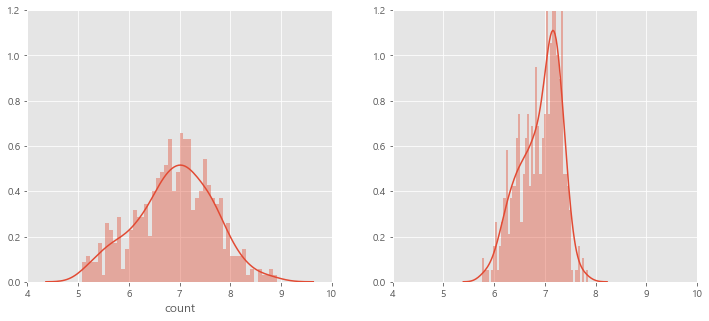

In [29]:
predictions=model.predict(x_test)
fig, (ax1,ax2)=plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_test,ax=ax1,bins=50)
ax1.set_xlim(4,10)
ax1.set_ylim(0,1.2)
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set_xlim(4,10)
ax2.set_ylim(0,1.2)

In [30]:
pred=pd.DataFrame(predictions,columns=['pred'])
t=pd.DataFrame(y_test).reset_index(drop=True)
p=pd.concat([t,pred],axis=1)

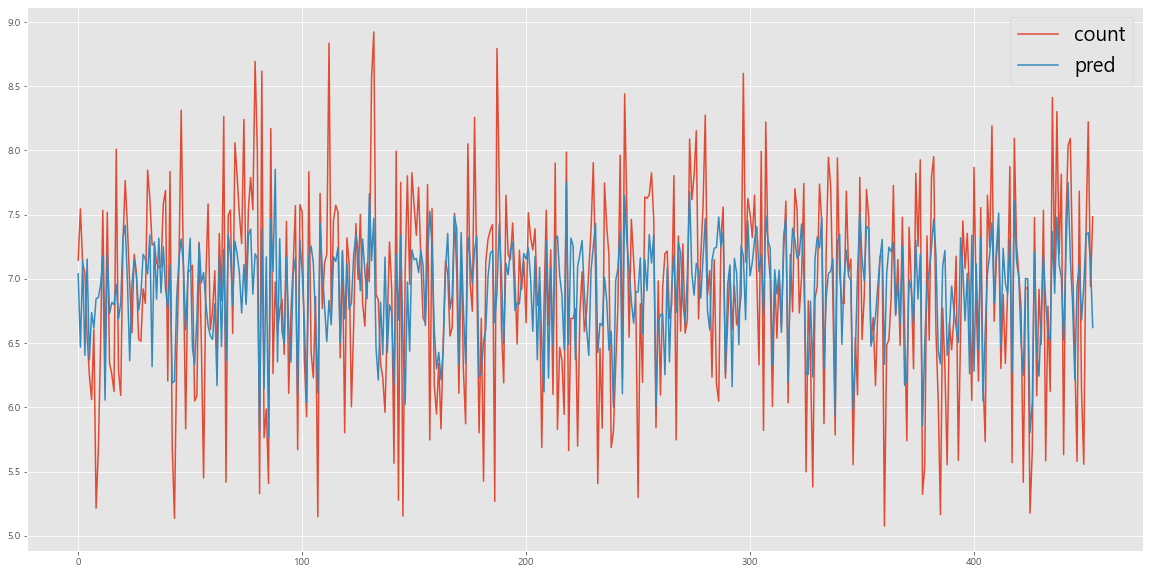

In [31]:
fig,ax=plt.subplots(1)
fig.set_size_inches(20,10)
p.plot(ax=ax)
ax.legend(fontsize=20)
plt.show()

# XGBOOST

In [18]:
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.model_selection import cross_val_score
xgb.XGBRegressor()

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [19]:
rental_data['starbucks']=rental_data['starbucks'].astype('int')
rental_data['PB']=rental_data['PB'].astype('int')
rental_data['상업지역']=rental_data['상업지역'].astype('int')

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(rental_data, test_size=0.3, random_state=0)
train.shape, test.shape

((1059, 22), (454, 22))

In [21]:
x_train=train.drop('count',axis=1)
y_train=train['count']
x_test=test.drop('count',axis=1)
y_test=test['count']

## 1차 파라미터 조정

### K-Fold Validation
* 셔플 5회

In [22]:
num_epoch = 500
xgt_hyperparameters_list = []
for epoch in range(num_epoch):
    n_estimators = np.random.randint(low=100, high=1000) # 트리의 갯수
    max_depth = np.random.randint(low=8, high=80) # 최대 깊이
    learning_rate = 10 ** -np.random.uniform(low=0, high=3)
    subsample = np.random.uniform(low=0.1, high=1.0) # 각 트리마다의 관측 데이터 샘플링 비율
    colsample_bytree = np.random.uniform(low=0.4, high=1.0) # 트리 생성할 때 변수를 샘플링해주는 비율
    colsample_bylevel = np.random.uniform(low=0.4, high=1.0) # 트리의 레벨별로 훈련데이터의 변수 샘플링해주는 비율
    model = xgb.XGBRegressor(booster='dart',
                             n_estimators=n_estimators,
                             max_depth=max_depth,
                             learning_rate=learning_rate,
                             subsample=subsample,
                             colsample_bylevel=colsample_bylevel,
                             colsample_bytree=colsample_bytree,
                             random_state=0,
                             seed=0,
                             nthread = 8) # 병렬 스레드 수
                             #tree_method = 'gpu_hist')
    k_fold = KFold(5, shuffle=True, random_state=0)
    score = cross_val_score(model, x_train, y_train, cv=k_fold, scoring=rmsle_scorer).mean()
    hyperparameters = {'epoch': epoch,'score': score,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'learning_rate': learning_rate,
                       'subsample': subsample,
                       'colsample_bylevel': colsample_bylevel,
                       'colsample_bytree': colsample_bytree}
    xgt_hyperparameters_list.append(hyperparameters)
    model.fit(x_train,y_train)
    success=0
    fail=0
    pred=model.predict(x_test)
    t=list(y_test)
    for p in range(len(pred)):
        if abs(pred[p]-t[p])<=0.4:
            success+=1
        else:
            fail+=1
    acc=success/(success+fail)*100
    print(f"{epoch:2} n_estimators = {n_estimators}, max_depth = {max_depth:2},learning_rate = {learning_rate:.10f}, subsample = {subsample:.6f}, colsample_bylevel = {colsample_bylevel:.6f}, colsample_bytree = {colsample_bytree:.6f}, Score = {score:.5f},model_score = {model.score(x_test,y_test):.7f},accuary={acc:.7f}")

xgt_hyperparameters_df = pd.DataFrame.from_dict(xgt_hyperparameters_list)

xgt_hyperparameters_df = xgt_hyperparameters_df.sort_values(by="score")
print(xgt_hyperparameters_df.shape)
xgt_hyperparameters_df.head(10)

 0 n_estimators = 151, max_depth = 52,learning_rate = 0.0725002831, subsample = 0.235769, colsample_bylevel = 0.675571, colsample_bytree = 0.599739, Score = 0.08663,model_score = 0.2951758,accuary=47.7973568
 1 n_estimators = 227, max_depth = 14,learning_rate = 0.0284512397, subsample = 0.113134, colsample_bylevel = 0.914563, colsample_bytree = 0.441756, Score = 0.08499,model_score = 0.3477854,accuary=50.0000000
 2 n_estimators = 785, max_depth = 39,learning_rate = 0.0067000221, subsample = 0.840580, colsample_bylevel = 0.454762, colsample_bytree = 0.909668, Score = 0.08258,model_score = 0.3733594,accuary=48.8986784
 3 n_estimators = 322, max_depth = 78,learning_rate = 0.0515113541, subsample = 0.967085, colsample_bylevel = 0.531753, colsample_bytree = 0.568316, Score = 0.08327,model_score = 0.3599172,accuary=47.5770925
 4 n_estimators = 129, max_depth = 49,learning_rate = 0.1130964265, subsample = 0.468564, colsample_bylevel = 0.524798, colsample_bytree = 0.527494, Score = 0.08508,mod

40 n_estimators = 310, max_depth = 79,learning_rate = 0.0072280338, subsample = 0.471779, colsample_bylevel = 0.814493, colsample_bytree = 0.733943, Score = 0.12762,model_score = -0.6044852,accuary=25.1101322
41 n_estimators = 730, max_depth = 47,learning_rate = 0.0414515883, subsample = 0.525398, colsample_bylevel = 0.688182, colsample_bytree = 0.506463, Score = 0.08387,model_score = 0.3835689,accuary=49.3392070
42 n_estimators = 300, max_depth = 15,learning_rate = 0.0195192791, subsample = 0.538927, colsample_bylevel = 0.525662, colsample_bytree = 0.712877, Score = 0.08261,model_score = 0.3861436,accuary=47.7973568
43 n_estimators = 590, max_depth = 49,learning_rate = 0.1985810189, subsample = 0.741216, colsample_bylevel = 0.843029, colsample_bytree = 0.441563, Score = 0.08879,model_score = 0.3283966,accuary=47.7973568
44 n_estimators = 822, max_depth = 40,learning_rate = 0.6351272407, subsample = 0.659909, colsample_bylevel = 0.913435, colsample_bytree = 0.836184, Score = 0.10834,mo

80 n_estimators = 150, max_depth = 37,learning_rate = 0.1143638152, subsample = 0.496289, colsample_bylevel = 0.787778, colsample_bytree = 0.742081, Score = 0.08657,model_score = 0.3591968,accuary=52.2026432
81 n_estimators = 266, max_depth = 44,learning_rate = 0.0058661106, subsample = 0.646411, colsample_bylevel = 0.805743, colsample_bytree = 0.492241, Score = 0.20503,model_score = -2.9177118,accuary=9.0308370
82 n_estimators = 109, max_depth = 48,learning_rate = 0.0012118736, subsample = 0.552139, colsample_bylevel = 0.956499, colsample_bytree = 0.936481, Score = 1.24014,model_score = -54.3482106,accuary=0.0000000
83 n_estimators = 696, max_depth = 46,learning_rate = 0.0013930737, subsample = 0.586814, colsample_bylevel = 0.878109, colsample_bytree = 0.585491, Score = 0.37596,model_score = -9.9984494,accuary=0.0000000
84 n_estimators = 157, max_depth = 76,learning_rate = 0.0112839784, subsample = 0.925303, colsample_bylevel = 0.868573, colsample_bytree = 0.449316, Score = 0.17091,mo

120 n_estimators = 916, max_depth = 38,learning_rate = 0.0011556391, subsample = 0.287811, colsample_bylevel = 0.540571, colsample_bytree = 0.768295, Score = 0.34179,model_score = -8.3950908,accuary=0.0000000
121 n_estimators = 376, max_depth = 61,learning_rate = 0.0052801777, subsample = 0.551517, colsample_bylevel = 0.956589, colsample_bytree = 0.963267, Score = 0.14920,model_score = -1.1569830,accuary=16.0792952
122 n_estimators = 332, max_depth = 77,learning_rate = 0.0741206849, subsample = 0.171115, colsample_bylevel = 0.835482, colsample_bytree = 0.768187, Score = 0.08889,model_score = 0.2054985,accuary=45.5947137
123 n_estimators = 222, max_depth = 67,learning_rate = 0.0530658400, subsample = 0.254943, colsample_bylevel = 0.969264, colsample_bytree = 0.781271, Score = 0.08526,model_score = 0.3440380,accuary=47.5770925
124 n_estimators = 738, max_depth = 19,learning_rate = 0.6923120859, subsample = 0.164201, colsample_bylevel = 0.961121, colsample_bytree = 0.849300, Score = nan,m

160 n_estimators = 577, max_depth = 76,learning_rate = 0.6992044432, subsample = 0.466172, colsample_bylevel = 0.851230, colsample_bytree = 0.563712, Score = 0.13089,model_score = -0.7108938,accuary=31.0572687
161 n_estimators = 395, max_depth = 59,learning_rate = 0.0042547787, subsample = 0.986254, colsample_bylevel = 0.977829, colsample_bytree = 0.809434, Score = 0.18517,model_score = -2.2495722,accuary=10.3524229
162 n_estimators = 160, max_depth = 20,learning_rate = 0.0075341612, subsample = 0.765392, colsample_bylevel = 0.606676, colsample_bytree = 0.940589, Score = 0.28896,model_score = -6.1050367,accuary=1.3215859
163 n_estimators = 538, max_depth = 27,learning_rate = 0.1340241253, subsample = 0.905068, colsample_bylevel = 0.557819, colsample_bytree = 0.860341, Score = 0.08460,model_score = 0.3357757,accuary=49.1189427
164 n_estimators = 975, max_depth = 27,learning_rate = 0.0922547334, subsample = 0.758163, colsample_bylevel = 0.706779, colsample_bytree = 0.610255, Score = 0.08

200 n_estimators = 188, max_depth = 61,learning_rate = 0.0071917622, subsample = 0.129679, colsample_bylevel = 0.862884, colsample_bytree = 0.847957, Score = 0.25520,model_score = -4.6387081,accuary=4.1850220
201 n_estimators = 252, max_depth = 74,learning_rate = 0.0192969905, subsample = 0.585907, colsample_bylevel = 0.702747, colsample_bytree = 0.634300, Score = 0.08341,model_score = 0.3598014,accuary=46.6960352
202 n_estimators = 379, max_depth = 43,learning_rate = 0.0010383543, subsample = 0.479091, colsample_bylevel = 0.424290, colsample_bytree = 0.800586, Score = 0.79460,model_score = -32.1155742,accuary=0.0000000
203 n_estimators = 202, max_depth = 67,learning_rate = 0.3828043826, subsample = 0.395502, colsample_bylevel = 0.555207, colsample_bytree = 0.580065, Score = 0.10981,model_score = -0.0599358,accuary=40.5286344
204 n_estimators = 741, max_depth = 61,learning_rate = 0.1005866112, subsample = 0.766788, colsample_bylevel = 0.404989, colsample_bytree = 0.674258, Score = 0.08

240 n_estimators = 373, max_depth = 39,learning_rate = 0.1445329680, subsample = 0.472007, colsample_bylevel = 0.409893, colsample_bytree = 0.861950, Score = 0.08840,model_score = 0.3139472,accuary=47.1365639
241 n_estimators = 558, max_depth = 17,learning_rate = 0.0109004192, subsample = 0.650211, colsample_bylevel = 0.963723, colsample_bytree = 0.726861, Score = 0.08277,model_score = 0.3865728,accuary=48.6784141
242 n_estimators = 998, max_depth = 33,learning_rate = 0.0050128458, subsample = 0.223618, colsample_bylevel = 0.897870, colsample_bytree = 0.445188, Score = 0.08333,model_score = 0.3743497,accuary=45.3744493
243 n_estimators = 762, max_depth = 52,learning_rate = 0.0184302678, subsample = 0.531355, colsample_bylevel = 0.983550, colsample_bytree = 0.905119, Score = 0.08279,model_score = 0.3668155,accuary=50.6607930
244 n_estimators = 647, max_depth = 35,learning_rate = 0.0042416940, subsample = 0.308337, colsample_bylevel = 0.608073, colsample_bytree = 0.649881, Score = 0.1037

280 n_estimators = 917, max_depth = 56,learning_rate = 0.0025601356, subsample = 0.838793, colsample_bylevel = 0.789962, colsample_bytree = 0.427215, Score = 0.11950,model_score = -0.4277870,accuary=27.7533040
281 n_estimators = 223, max_depth = 50,learning_rate = 0.0022574621, subsample = 0.325042, colsample_bylevel = 0.407772, colsample_bytree = 0.459062, Score = 0.67741,model_score = -25.7345482,accuary=0.0000000
282 n_estimators = 904, max_depth = 39,learning_rate = 0.8060936337, subsample = 0.432628, colsample_bylevel = 0.688494, colsample_bytree = 0.448648, Score = 0.16545,model_score = -1.0035057,accuary=31.7180617
283 n_estimators = 462, max_depth = 67,learning_rate = 0.0603939352, subsample = 0.422254, colsample_bylevel = 0.620808, colsample_bytree = 0.642159, Score = 0.08447,model_score = 0.3482139,accuary=46.6960352
284 n_estimators = 236, max_depth = 37,learning_rate = 0.0166016104, subsample = 0.414243, colsample_bylevel = 0.576374, colsample_bytree = 0.662044, Score = 0.0

320 n_estimators = 440, max_depth = 48,learning_rate = 0.9473915077, subsample = 0.275945, colsample_bylevel = 0.740561, colsample_bytree = 0.606639, Score = nan,model_score = -125200156161685856.0000000,accuary=0.0000000
321 n_estimators = 210, max_depth = 62,learning_rate = 0.0038034567, subsample = 0.269755, colsample_bylevel = 0.802949, colsample_bytree = 0.942493, Score = 0.46100,model_score = -14.1696819,accuary=0.0000000
322 n_estimators = 797, max_depth = 11,learning_rate = 0.0015841662, subsample = 0.601803, colsample_bylevel = 0.626484, colsample_bytree = 0.927326, Score = 0.27398,model_score = -5.4856857,accuary=2.2026432
323 n_estimators = 478, max_depth = 58,learning_rate = 0.0039190571, subsample = 0.964868, colsample_bylevel = 0.551329, colsample_bytree = 0.695967, Score = 0.15876,model_score = -1.4545585,accuary=14.3171806
324 n_estimators = 135, max_depth = 10,learning_rate = 0.0213984477, subsample = 0.199174, colsample_bylevel = 0.906368, colsample_bytree = 0.645451,

359 n_estimators = 617, max_depth = 67,learning_rate = 0.0010266516, subsample = 0.106320, colsample_bylevel = 0.820254, colsample_bytree = 0.617406, Score = 0.57193,model_score = -19.9646242,accuary=0.0000000
360 n_estimators = 629, max_depth = 68,learning_rate = 0.6187808533, subsample = 0.223898, colsample_bylevel = 0.451065, colsample_bytree = 0.943850, Score = nan,model_score = -65.3746916,accuary=5.5066079
361 n_estimators = 213, max_depth = 22,learning_rate = 0.0050975230, subsample = 0.238411, colsample_bylevel = 0.435115, colsample_bytree = 0.736938, Score = 0.33140,model_score = -7.9067326,accuary=0.0000000
362 n_estimators = 882, max_depth = 58,learning_rate = 0.0035647579, subsample = 0.960166, colsample_bylevel = 0.641440, colsample_bytree = 0.664994, Score = 0.09269,model_score = 0.1735198,accuary=39.6475771
363 n_estimators = 660, max_depth = 23,learning_rate = 0.0030900146, subsample = 0.886591, colsample_bylevel = 0.807484, colsample_bytree = 0.715159, Score = 0.14230,

399 n_estimators = 807, max_depth = 66,learning_rate = 0.0045340891, subsample = 0.501188, colsample_bylevel = 0.779777, colsample_bytree = 0.679418, Score = 0.08681,model_score = 0.2830391,accuary=42.0704846
400 n_estimators = 685, max_depth = 41,learning_rate = 0.0044328114, subsample = 0.466514, colsample_bylevel = 0.448322, colsample_bytree = 0.915711, Score = 0.09525,model_score = 0.1199290,accuary=38.5462555
401 n_estimators = 470, max_depth = 36,learning_rate = 0.0267302297, subsample = 0.929839, colsample_bylevel = 0.480254, colsample_bytree = 0.426299, Score = 0.08303,model_score = 0.3772022,accuary=48.8986784
402 n_estimators = 411, max_depth = 47,learning_rate = 0.0103181300, subsample = 0.496161, colsample_bylevel = 0.559420, colsample_bytree = 0.907323, Score = 0.08422,model_score = 0.3514976,accuary=47.3568282
403 n_estimators = 847, max_depth = 13,learning_rate = 0.0114865639, subsample = 0.986597, colsample_bylevel = 0.769075, colsample_bytree = 0.482061, Score = 0.0826

439 n_estimators = 575, max_depth = 78,learning_rate = 0.0014320779, subsample = 0.222134, colsample_bylevel = 0.903523, colsample_bytree = 0.411512, Score = 0.44836,model_score = -13.5295771,accuary=0.0000000
440 n_estimators = 486, max_depth = 35,learning_rate = 0.0127394569, subsample = 0.498725, colsample_bylevel = 0.939476, colsample_bytree = 0.853618, Score = 0.08235,model_score = 0.3789105,accuary=49.3392070
441 n_estimators = 771, max_depth = 56,learning_rate = 0.0035475670, subsample = 0.747125, colsample_bylevel = 0.446287, colsample_bytree = 0.728155, Score = 0.10228,model_score = -0.0337467,accuary=35.2422907
442 n_estimators = 716, max_depth =  9,learning_rate = 0.0019302252, subsample = 0.529747, colsample_bylevel = 0.845881, colsample_bytree = 0.927101, Score = 0.24384,model_score = -4.2876227,accuary=3.9647577
443 n_estimators = 916, max_depth = 33,learning_rate = 0.0017275011, subsample = 0.419515, colsample_bylevel = 0.653849, colsample_bytree = 0.570751, Score = 0.20

478 n_estimators = 656, max_depth = 54,learning_rate = 0.0463312571, subsample = 0.316628, colsample_bylevel = 0.908082, colsample_bytree = 0.867270, Score = 0.08437,model_score = 0.3215074,accuary=48.6784141
479 n_estimators = 265, max_depth = 10,learning_rate = 0.4154890784, subsample = 0.567170, colsample_bylevel = 0.464209, colsample_bytree = 0.878996, Score = 0.09862,model_score = 0.0632288,accuary=40.9691630
480 n_estimators = 324, max_depth = 25,learning_rate = 0.1276558007, subsample = 0.491687, colsample_bylevel = 0.454606, colsample_bytree = 0.734658, Score = 0.08615,model_score = 0.3322269,accuary=46.6960352
481 n_estimators = 778, max_depth = 22,learning_rate = 0.5506495052, subsample = 0.854937, colsample_bylevel = 0.966369, colsample_bytree = 0.816170, Score = 0.10137,model_score = 0.0343449,accuary=44.0528634
482 n_estimators = 575, max_depth = 17,learning_rate = 0.6398870757, subsample = 0.288906, colsample_bylevel = 0.420719, colsample_bytree = 0.436265, Score = 0.1876

,epoch,score,n_estimators,max_depth,learning_rate,subsample,colsample_bylevel,colsample_bytree
133,133,0.081905,857,42,0.045057,0.698293,0.632239,0.631538
193,193,0.082136,599,61,0.011039,0.532920,0.671052,0.818423
87,87,0.082139,979,36,0.009597,0.396116,0.751963,0.494537
197,197,0.082149,547,20,0.016994,0.802605,0.817095,0.474285
92,92,0.082159,773,47,0.014001,0.772278,0.519273,0.730062
393,393,0.082220,222,10,0.037054,0.749072,0.511251,0.705997
409,409,0.082226,957,28,0.006602,0.950521,0.550556,0.828536
205,205,0.082262,146,46,0.052282,0.654191,0.456899,0.894644
356,356,0.082284,862,9,0.025903,0.713923,0.726408,0.719245
97,97,0.082292,528,37,0.012581,0.671886,0.968210,0.631935


In [432]:
xgt_hyperparameters_df.head(50)

,epoch,score,n_estimators,max_depth,learning_rate,subsample,colsample_bylevel,colsample_bytree
212,212,0.081834,858,8,0.011657,0.570679,0.910096,0.637541
15,15,0.081969,780,46,0.006986,0.830024,0.405978,0.642187
325,325,0.082053,927,17,0.008198,0.890977,0.401465,0.521863
469,469,0.082076,614,42,0.011237,0.278583,0.535078,0.565570
281,281,0.082091,974,53,0.015078,0.421209,0.410385,0.600249
273,273,0.082100,953,28,0.008173,0.482827,0.618742,0.961956
372,372,0.082109,281,17,0.034912,0.887518,0.748696,0.761818
303,303,0.082132,470,12,0.015461,0.315712,0.735838,0.649910
309,309,0.082145,640,15,0.011777,0.842932,0.518054,0.485942
368,368,0.082149,710,58,0.017552,0.511202,0.876390,0.637469


## 2차 하이퍼 파라미터 조정
* 1차 조정 결과를 바탕으로 2차 조정

In [23]:
num_epoch = 500
fin_xgt_hyperparameters_list = []
for epoch in range(num_epoch):
    n_estimators = np.random.randint(low=300, high=900) # 트리의 갯수
    max_depth = np.random.randint(low=20, high=60) # 최대 깊이
    learning_rate = 10 ** -np.random.uniform(low=2, high=3)
    subsample = np.random.uniform(low=0.3, high=1.0) # 각 트리마다의 관측 데이터 샘플링 비율
    colsample_bytree = np.random.uniform(low=0.4, high=1.0) # 트리 생성할 때 변수를 샘플링해주는 비율
    colsample_bylevel = np.random.uniform(low=0.4, high=1.0) # 트리의 레벨별로 훈련데이터의 변수 샘플링해주는 비율
    model = xgb.XGBRegressor(booster='dart',
                             n_estimators=n_estimators,
                             max_depth=max_depth,
                             learning_rate=learning_rate,
                             subsample=subsample,
                             colsample_bylevel=colsample_bylevel,
                             colsample_bytree=colsample_bytree,
                             random_state=0,
                             seed=0,
                             nthread = 8) # 병렬 스레드 수
                             #tree_method = 'gpu_hist')
    k_fold = KFold(5, shuffle=True, random_state=0)
    score = cross_val_score(model, x_train, y_train, cv=k_fold, scoring=rmsle_scorer).mean()
    model.fit(x_train,y_train)
    success=0
    fail=0
    pred=model.predict(x_test)
    t=list(y_test)
    for p in range(len(pred)):
        if abs(pred[p]-t[p])<=0.4:
            success+=1
        else:
            fail+=1
    acc=success/(success+fail)*100
    hyperparameters = {'epoch': epoch,'score': score,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'learning_rate': learning_rate,
                       'subsample': subsample,
                       'colsample_bylevel': colsample_bylevel,
                       'colsample_bytree': colsample_bytree,
                      'accuracy':acc}
    fin_xgt_hyperparameters_list.append(hyperparameters)

    print(f"{epoch:2} n_estimators = {n_estimators}, max_depth = {max_depth:2},learning_rate = {learning_rate:.10f}, subsample = {subsample:.6f}, colsample_bylevel = {colsample_bylevel:.6f}, colsample_bytree = {colsample_bytree:.6f}, Score = {score:.5f},model_score = {model.score(x_test,y_test):.7f},accuary={acc:.7f}")

fin_xgt_hyperparameters_df = pd.DataFrame.from_dict(fin_xgt_hyperparameters_list)

fin_xgt_hyperparameters_df = fin_xgt_hyperparameters_df.sort_values(by="score")
print(fin_xgt_hyperparameters_df.shape)
fin_xgt_hyperparameters_df.head(10)

 0 n_estimators = 801, max_depth = 59,learning_rate = 0.0089696186, subsample = 0.649752, colsample_bylevel = 0.777930, colsample_bytree = 0.874587, Score = 0.08223,model_score = 0.3800811,accuary=48.8986784
 1 n_estimators = 897, max_depth = 50,learning_rate = 0.0021635156, subsample = 0.314514, colsample_bylevel = 0.973941, colsample_bytree = 0.995052, Score = 0.15558,model_score = -1.3265954,accuary=15.4185022
 2 n_estimators = 332, max_depth = 50,learning_rate = 0.0023823220, subsample = 0.651067, colsample_bylevel = 0.587187, colsample_bytree = 0.584301, Score = 0.46412,model_score = -14.3653849,accuary=0.0000000
 3 n_estimators = 389, max_depth = 47,learning_rate = 0.0028108933, subsample = 0.980895, colsample_bylevel = 0.450636, colsample_bytree = 0.716977, Score = 0.32617,model_score = -7.7337546,accuary=0.0000000
 4 n_estimators = 465, max_depth = 28,learning_rate = 0.0088221233, subsample = 0.436768, colsample_bylevel = 0.683677, colsample_bytree = 0.711853, Score = 0.08491,m

40 n_estimators = 730, max_depth = 43,learning_rate = 0.0049152668, subsample = 0.371608, colsample_bylevel = 0.911936, colsample_bytree = 0.830755, Score = 0.08830,model_score = 0.2800568,accuary=44.7136564
41 n_estimators = 825, max_depth = 51,learning_rate = 0.0076816972, subsample = 0.952352, colsample_bylevel = 0.754493, colsample_bytree = 0.545224, Score = 0.08226,model_score = 0.3795209,accuary=49.3392070
42 n_estimators = 571, max_depth = 27,learning_rate = 0.0074511274, subsample = 0.576908, colsample_bylevel = 0.861428, colsample_bytree = 0.802473, Score = 0.08397,model_score = 0.3534149,accuary=46.6960352
43 n_estimators = 801, max_depth = 47,learning_rate = 0.0021424403, subsample = 0.770019, colsample_bylevel = 0.618944, colsample_bytree = 0.845534, Score = 0.18048,model_score = -2.0970752,accuary=10.7929515
44 n_estimators = 405, max_depth = 35,learning_rate = 0.0025454707, subsample = 0.979733, colsample_bylevel = 0.778174, colsample_bytree = 0.999951, Score = 0.34975,mo

80 n_estimators = 858, max_depth = 38,learning_rate = 0.0098153409, subsample = 0.667020, colsample_bylevel = 0.605029, colsample_bytree = 0.939132, Score = 0.08216,model_score = 0.3846186,accuary=50.4405286
81 n_estimators = 513, max_depth = 22,learning_rate = 0.0013167388, subsample = 0.416707, colsample_bylevel = 0.623581, colsample_bytree = 0.692310, Score = 0.53760,model_score = -18.1982269,accuary=0.0000000
82 n_estimators = 709, max_depth = 46,learning_rate = 0.0029527601, subsample = 0.355742, colsample_bylevel = 0.962559, colsample_bytree = 0.431839, Score = 0.13949,model_score = -0.9103711,accuary=21.3656388
83 n_estimators = 664, max_depth = 47,learning_rate = 0.0061410795, subsample = 0.373154, colsample_bylevel = 0.648612, colsample_bytree = 0.971139, Score = 0.08496,model_score = 0.3379608,accuary=46.6960352
84 n_estimators = 809, max_depth = 48,learning_rate = 0.0095965915, subsample = 0.310235, colsample_bylevel = 0.862837, colsample_bytree = 0.818929, Score = 0.08182,m

120 n_estimators = 762, max_depth = 36,learning_rate = 0.0013259825, subsample = 0.769819, colsample_bylevel = 0.693908, colsample_bytree = 0.602798, Score = 0.35849,model_score = -9.1916346,accuary=0.0000000
121 n_estimators = 844, max_depth = 55,learning_rate = 0.0015166551, subsample = 0.952468, colsample_bylevel = 0.990706, colsample_bytree = 0.711341, Score = 0.26824,model_score = -5.2605028,accuary=2.6431718
122 n_estimators = 844, max_depth = 23,learning_rate = 0.0015559888, subsample = 0.483702, colsample_bylevel = 0.648946, colsample_bytree = 0.805822, Score = 0.26071,model_score = -4.9512300,accuary=2.8634361
123 n_estimators = 683, max_depth = 58,learning_rate = 0.0098647039, subsample = 0.495333, colsample_bylevel = 0.806984, colsample_bytree = 0.530441, Score = 0.08226,model_score = 0.3964379,accuary=49.3392070
124 n_estimators = 735, max_depth = 25,learning_rate = 0.0076195409, subsample = 0.559411, colsample_bylevel = 0.570784, colsample_bytree = 0.553256, Score = 0.0824

160 n_estimators = 321, max_depth = 49,learning_rate = 0.0014406851, subsample = 0.545523, colsample_bylevel = 0.484778, colsample_bytree = 0.871767, Score = 0.71754,model_score = -27.9514942,accuary=0.0000000
161 n_estimators = 779, max_depth = 34,learning_rate = 0.0052098617, subsample = 0.818322, colsample_bylevel = 0.944836, colsample_bytree = 0.899879, Score = 0.08507,model_score = 0.3262994,accuary=46.2555066
162 n_estimators = 308, max_depth = 27,learning_rate = 0.0022268525, subsample = 0.917670, colsample_bylevel = 0.405920, colsample_bytree = 0.582747, Score = 0.52926,model_score = -17.7727920,accuary=0.0000000
163 n_estimators = 333, max_depth = 38,learning_rate = 0.0038966205, subsample = 0.372086, colsample_bylevel = 0.715716, colsample_bytree = 0.991845, Score = 0.26533,model_score = -5.1214172,accuary=2.6431718
164 n_estimators = 448, max_depth = 50,learning_rate = 0.0075064340, subsample = 0.484259, colsample_bylevel = 0.732835, colsample_bytree = 0.866224, Score = 0.09

200 n_estimators = 403, max_depth = 31,learning_rate = 0.0084675162, subsample = 0.642244, colsample_bylevel = 0.581626, colsample_bytree = 0.723811, Score = 0.08927,model_score = 0.2437680,accuary=41.6299559
201 n_estimators = 724, max_depth = 48,learning_rate = 0.0015263138, subsample = 0.303555, colsample_bylevel = 0.544374, colsample_bytree = 0.984363, Score = 0.32490,model_score = -7.6435374,accuary=0.0000000
202 n_estimators = 560, max_depth = 36,learning_rate = 0.0087723047, subsample = 0.940406, colsample_bylevel = 0.651112, colsample_bytree = 0.650405, Score = 0.08334,model_score = 0.3706874,accuary=48.8986784
203 n_estimators = 870, max_depth = 40,learning_rate = 0.0025512325, subsample = 0.776050, colsample_bylevel = 0.705969, colsample_bytree = 0.544576, Score = 0.12776,model_score = -0.6241454,accuary=24.6696035
204 n_estimators = 678, max_depth = 35,learning_rate = 0.0035730715, subsample = 0.985217, colsample_bylevel = 0.572889, colsample_bytree = 0.400092, Score = 0.114

240 n_estimators = 568, max_depth = 32,learning_rate = 0.0013791992, subsample = 0.553154, colsample_bylevel = 0.687907, colsample_bytree = 0.817388, Score = 0.46899,model_score = -14.6121246,accuary=0.0000000
241 n_estimators = 491, max_depth = 47,learning_rate = 0.0055048247, subsample = 0.810273, colsample_bylevel = 0.633036, colsample_bytree = 0.673741, Score = 0.10348,model_score = -0.0529008,accuary=34.3612335
242 n_estimators = 493, max_depth = 48,learning_rate = 0.0065662291, subsample = 0.624676, colsample_bylevel = 0.961175, colsample_bytree = 0.559588, Score = 0.09172,model_score = 0.2044118,accuary=41.4096916
243 n_estimators = 752, max_depth = 56,learning_rate = 0.0016926316, subsample = 0.379512, colsample_bylevel = 0.779316, colsample_bytree = 0.967740, Score = 0.27254,model_score = -5.4044766,accuary=2.2026432
244 n_estimators = 387, max_depth = 50,learning_rate = 0.0028322784, subsample = 0.964170, colsample_bylevel = 0.679219, colsample_bytree = 0.677754, Score = 0.32

280 n_estimators = 325, max_depth = 29,learning_rate = 0.0010170861, subsample = 0.681292, colsample_bylevel = 0.967086, colsample_bytree = 0.715115, Score = 0.87551,model_score = -36.4580099,accuary=0.0000000
281 n_estimators = 536, max_depth = 57,learning_rate = 0.0073964434, subsample = 0.708042, colsample_bylevel = 0.645012, colsample_bytree = 0.972310, Score = 0.08525,model_score = 0.3229256,accuary=44.9339207
282 n_estimators = 477, max_depth = 53,learning_rate = 0.0023927038, subsample = 0.864388, colsample_bylevel = 0.683708, colsample_bytree = 0.491077, Score = 0.30975,model_score = -7.0127439,accuary=0.2202643
283 n_estimators = 559, max_depth = 27,learning_rate = 0.0023788857, subsample = 0.629748, colsample_bylevel = 0.529678, colsample_bytree = 0.651088, Score = 0.25553,model_score = -4.7525879,accuary=3.3039648
284 n_estimators = 423, max_depth = 20,learning_rate = 0.0020074281, subsample = 0.401995, colsample_bylevel = 0.522498, colsample_bytree = 0.834070, Score = 0.433

320 n_estimators = 772, max_depth = 59,learning_rate = 0.0064712581, subsample = 0.680356, colsample_bylevel = 0.604525, colsample_bytree = 0.402313, Score = 0.08319,model_score = 0.3675405,accuary=46.6960352
321 n_estimators = 851, max_depth = 45,learning_rate = 0.0011957429, subsample = 0.819881, colsample_bylevel = 0.416670, colsample_bytree = 0.551185, Score = 0.35551,model_score = -9.0610244,accuary=0.0000000
322 n_estimators = 560, max_depth = 58,learning_rate = 0.0031416952, subsample = 0.407567, colsample_bylevel = 0.945478, colsample_bytree = 0.590742, Score = 0.17567,model_score = -1.9356891,accuary=13.6563877
323 n_estimators = 461, max_depth = 47,learning_rate = 0.0068765954, subsample = 0.474775, colsample_bylevel = 0.801587, colsample_bytree = 0.697581, Score = 0.09294,model_score = 0.1712329,accuary=40.0881057
324 n_estimators = 758, max_depth = 30,learning_rate = 0.0077228890, subsample = 0.604884, colsample_bylevel = 0.935051, colsample_bytree = 0.677332, Score = 0.082

360 n_estimators = 379, max_depth = 45,learning_rate = 0.0086489745, subsample = 0.419054, colsample_bylevel = 0.817832, colsample_bytree = 0.620324, Score = 0.09131,model_score = 0.2071973,accuary=41.1894273
361 n_estimators = 701, max_depth = 21,learning_rate = 0.0010400897, subsample = 0.344200, colsample_bylevel = 0.422287, colsample_bytree = 0.558234, Score = 0.50249,model_score = -16.3373156,accuary=0.0000000
362 n_estimators = 378, max_depth = 27,learning_rate = 0.0066407125, subsample = 0.578728, colsample_bylevel = 0.988114, colsample_bytree = 0.444447, Score = 0.11175,model_score = -0.2382489,accuary=31.2775330
363 n_estimators = 460, max_depth = 51,learning_rate = 0.0092267420, subsample = 0.775031, colsample_bylevel = 0.789650, colsample_bytree = 0.563354, Score = 0.08409,model_score = 0.3506087,accuary=45.5947137
364 n_estimators = 645, max_depth = 53,learning_rate = 0.0011345695, subsample = 0.465108, colsample_bylevel = 0.477930, colsample_bytree = 0.440050, Score = 0.50

400 n_estimators = 723, max_depth = 27,learning_rate = 0.0058970773, subsample = 0.907214, colsample_bylevel = 0.840733, colsample_bytree = 0.789996, Score = 0.08410,model_score = 0.3440012,accuary=48.2378855
401 n_estimators = 800, max_depth = 55,learning_rate = 0.0052812438, subsample = 0.679472, colsample_bylevel = 0.969774, colsample_bytree = 0.631429, Score = 0.08417,model_score = 0.3520079,accuary=46.0352423
402 n_estimators = 727, max_depth = 54,learning_rate = 0.0014458501, subsample = 0.458755, colsample_bylevel = 0.404296, colsample_bytree = 0.788744, Score = 0.34338,model_score = -8.4826432,accuary=0.0000000
403 n_estimators = 300, max_depth = 44,learning_rate = 0.0023015528, subsample = 0.870670, colsample_bylevel = 0.518486, colsample_bytree = 0.795895, Score = 0.52618,model_score = -17.6184711,accuary=0.0000000
404 n_estimators = 848, max_depth = 28,learning_rate = 0.0031599454, subsample = 0.610556, colsample_bylevel = 0.850954, colsample_bytree = 0.688597, Score = 0.105

440 n_estimators = 595, max_depth = 28,learning_rate = 0.0021569546, subsample = 0.835589, colsample_bylevel = 0.531974, colsample_bytree = 0.926888, Score = 0.26747,model_score = -5.2323201,accuary=2.4229075
441 n_estimators = 404, max_depth = 32,learning_rate = 0.0022652751, subsample = 0.592624, colsample_bylevel = 0.596968, colsample_bytree = 0.600790, Score = 0.40019,model_score = -11.1654412,accuary=0.0000000
442 n_estimators = 524, max_depth = 30,learning_rate = 0.0027934303, subsample = 0.665564, colsample_bylevel = 0.584545, colsample_bytree = 0.916956, Score = 0.22498,model_score = -3.6015748,accuary=5.5066079
443 n_estimators = 791, max_depth = 48,learning_rate = 0.0089785440, subsample = 0.701067, colsample_bylevel = 0.984880, colsample_bytree = 0.916750, Score = 0.08252,model_score = 0.3815682,accuary=49.1189427
444 n_estimators = 722, max_depth = 45,learning_rate = 0.0053141089, subsample = 0.466741, colsample_bylevel = 0.689745, colsample_bytree = 0.504778, Score = 0.085

480 n_estimators = 675, max_depth = 35,learning_rate = 0.0017280776, subsample = 0.889886, colsample_bylevel = 0.445870, colsample_bytree = 0.514690, Score = 0.30174,model_score = -6.6716927,accuary=0.6607930
481 n_estimators = 520, max_depth = 26,learning_rate = 0.0038358085, subsample = 0.682742, colsample_bylevel = 0.842131, colsample_bytree = 0.948359, Score = 0.14763,model_score = -1.1110589,accuary=17.6211454
482 n_estimators = 700, max_depth = 53,learning_rate = 0.0012119750, subsample = 0.723928, colsample_bylevel = 0.402831, colsample_bytree = 0.634832, Score = 0.43302,model_score = -12.7924596,accuary=0.0000000
483 n_estimators = 593, max_depth = 41,learning_rate = 0.0021401287, subsample = 0.994013, colsample_bylevel = 0.416352, colsample_bytree = 0.765127, Score = 0.27081,model_score = -5.3837091,accuary=2.6431718
484 n_estimators = 429, max_depth = 53,learning_rate = 0.0011797135, subsample = 0.756932, colsample_bylevel = 0.751181, colsample_bytree = 0.989449, Score = 0.67

,epoch,score,n_estimators,max_depth,learning_rate,subsample,colsample_bylevel,colsample_bytree,accuracy
84,84,0.081825,809,48,0.009597,0.310235,0.862837,0.818929,46.696035
267,267,0.081885,875,41,0.009186,0.318157,0.963026,0.845038,50.881057
199,199,0.081906,664,26,0.009797,0.528199,0.716971,0.512903,46.916300
417,417,0.081952,757,58,0.007724,0.526015,0.516376,0.780666,49.559471
17,17,0.082024,720,22,0.008523,0.694957,0.508624,0.784798,50.220264
301,301,0.082048,892,24,0.007376,0.412152,0.530090,0.752888,48.898678
449,449,0.082137,864,24,0.006317,0.533607,0.887211,0.741845,49.559471
89,89,0.082138,802,56,0.009900,0.744289,0.579077,0.547748,48.898678
80,80,0.082160,858,38,0.009815,0.667020,0.605029,0.939132,50.440529
349,349,0.082188,762,57,0.009193,0.512497,0.851362,0.821897,50.000000


In [32]:
xgt_hyperparameters_df.head(10)

,epoch,score,n_estimators,max_depth,learning_rate,subsample,colsample_bylevel,colsample_bytree
133,133,0.081905,857,42,0.045057,0.698293,0.632239,0.631538
193,193,0.082136,599,61,0.011039,0.532920,0.671052,0.818423
87,87,0.082139,979,36,0.009597,0.396116,0.751963,0.494537
197,197,0.082149,547,20,0.016994,0.802605,0.817095,0.474285
92,92,0.082159,773,47,0.014001,0.772278,0.519273,0.730062
393,393,0.082220,222,10,0.037054,0.749072,0.511251,0.705997
409,409,0.082226,957,28,0.006602,0.950521,0.550556,0.828536
205,205,0.082262,146,46,0.052282,0.654191,0.456899,0.894644
356,356,0.082284,862,9,0.025903,0.713923,0.726408,0.719245
97,97,0.082292,528,37,0.012581,0.671886,0.968210,0.631935


In [33]:
fin_xgt_hyperparameters_df.head(10)

,epoch,score,n_estimators,max_depth,learning_rate,subsample,colsample_bylevel,colsample_bytree,accuracy
84,84,0.081825,809,48,0.009597,0.310235,0.862837,0.818929,46.696035
267,267,0.081885,875,41,0.009186,0.318157,0.963026,0.845038,50.881057
199,199,0.081906,664,26,0.009797,0.528199,0.716971,0.512903,46.916300
417,417,0.081952,757,58,0.007724,0.526015,0.516376,0.780666,49.559471
17,17,0.082024,720,22,0.008523,0.694957,0.508624,0.784798,50.220264
301,301,0.082048,892,24,0.007376,0.412152,0.530090,0.752888,48.898678
449,449,0.082137,864,24,0.006317,0.533607,0.887211,0.741845,49.559471
89,89,0.082138,802,56,0.009900,0.744289,0.579077,0.547748,48.898678
80,80,0.082160,858,38,0.009815,0.667020,0.605029,0.939132,50.440529
349,349,0.082188,762,57,0.009193,0.512497,0.851362,0.821897,50.000000


## XGBOOST 최적 모델

In [49]:
xgt_hyperparameters_df.loc[133]

epoch                133.000000
score                  0.081905
n_estimators         857.000000
max_depth             42.000000
learning_rate          0.045057
subsample              0.698293
colsample_bylevel      0.632239
colsample_bytree       0.631538
Name: 133, dtype: float64

In [50]:
model = xgb.XGBRegressor(booster='dart',
                         n_estimators=int(xgt_hyperparameters_df.loc[133]['n_estimators']),
                         max_depth=int(xgt_hyperparameters_df.loc[133]['max_depth']),
                         learning_rate=xgt_hyperparameters_df.loc[133]['learning_rate'],
                         subsample=xgt_hyperparameters_df.loc[133]['subsample'],
                         colsample_bylevel=xgt_hyperparameters_df.loc[133]['colsample_bylevel'],
                         colsample_bytree=xgt_hyperparameters_df.loc[133]['colsample_bytree'],
                         random_state=0,
                         seed=0,
                         nthread = 8) # 병렬 스레드 수
                         #tree_method = 'gpu_hist')
k_fold = KFold(5, shuffle=True, random_state=0)
score = cross_val_score(model, x_train, y_train, cv=k_fold, scoring=rmsle_scorer).mean()
model.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='dart',
             colsample_bylevel=0.6322388596442692, colsample_bynode=1,
             colsample_bytree=0.6315378106168728, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.045056732699448154, max_delta_step=0, max_depth=42,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=857, n_jobs=8, nthread=8, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=0, subsample=0.6982931299213423, tree_method='exact',
             validate_parameters=1, verbosity=None)

### RMSE SCORE

In [51]:
score

0.08190485414578279

(0.0, 1.2)

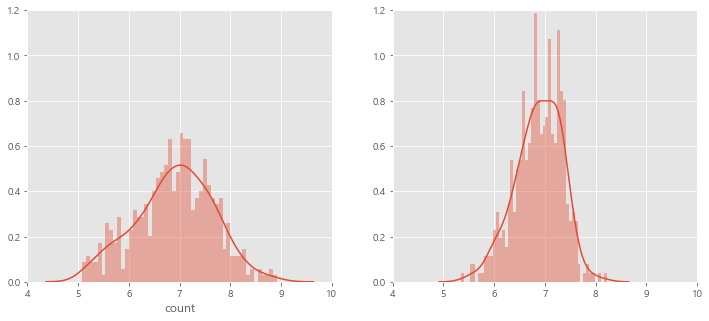

In [53]:
predictions=model.predict(x_test)
fig, (ax1,ax2)=plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_test,ax=ax1,bins=50)
ax1.set_xlim(4,10)
ax1.set_ylim(0,1.2)
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set_xlim(4,10)
ax2.set_ylim(0,1.2)

In [54]:
pred=pd.DataFrame(predictions,columns=['pred'])
t=pd.DataFrame(y_test).reset_index(drop=True)
p=pd.concat([t,pred],axis=1)

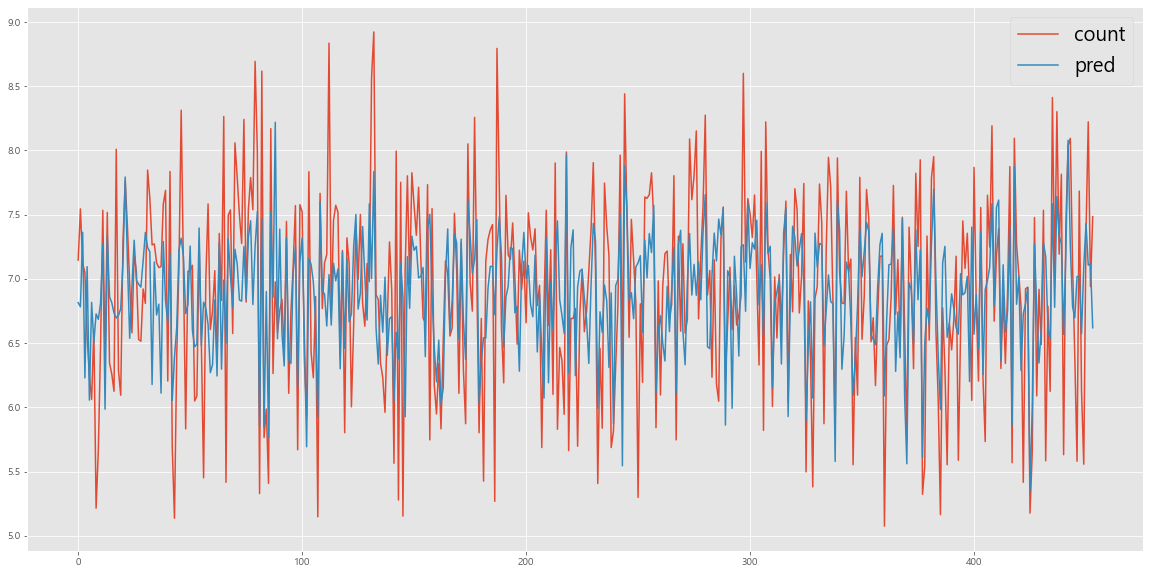

In [55]:
fig,ax=plt.subplots(1)
fig.set_size_inches(20,10)
p.plot(ax=ax)
ax.legend(fontsize=20)
plt.show()

# 격자 데이터 적용
* 50 x 50(m) 격자 데이터에 모델 적용
* 지역별 대여량 예측

In [56]:
grid_data=pd.read_csv('C:/Users/user/Desktop/서울시청/데이터/독립변수/test1222 최종격자.csv',encoding='cp949')

In [57]:
grid=grid_data['id']

In [58]:
grid_data=grid_data[[ 'subway',  '상업지역', 'weighted_LEN_mean', 'mean_width',
       '주거', 'school', 'sports', 'study', 'market', 'game', 
       'culture',  'parking', 'bike','bus_all', 'sub_all',
         '용적율', '지상층수', '대지면적', '인구','starbucks','PB']]

In [59]:
grid_data['starbucks']=grid_data['starbucks'].astype('int')
grid_data['PB']=grid_data['PB'].astype('int')
grid_data['상업지역']=grid_data['상업지역'].astype('int')

In [60]:
grid_data

,subway,상업지역,weighted_LEN_mean,mean_width,주거,school,sports,study,market,game,...,parking,bike,bus_all,sub_all,용적율,지상층수,대지면적,인구,starbucks,PB
0,18.507655,0,0.862636,6.745369,0.000000,28.377691,21.144173,5.909159,5.889715,6.205061,...,30.511870,12.633085,0.0,13.160083,0.000000,0.0,0.000000,0.0,0,0
1,19.797353,0,0.905400,6.745369,0.000000,29.205606,21.855557,6.020991,5.971249,6.258142,...,30.081118,14.180187,0.0,13.160083,0.000000,0.0,0.000000,0.0,0,0
2,21.010698,0,0.905400,6.745369,0.000000,30.014710,22.612031,6.124400,6.055224,6.314351,...,29.678765,15.675194,0.0,13.160083,0.000000,0.0,0.000000,0.0,0,0
3,22.159468,0,0.905400,6.745369,0.000000,30.805890,23.397220,6.219996,6.138829,6.372197,...,29.308927,16.640326,0.0,13.160083,0.000000,0.0,0.000000,0.0,0,0
4,23.252772,0,1.064580,6.745369,0.000000,31.580026,24.198824,6.308539,6.220382,6.430548,...,28.975848,17.109340,0.0,13.160083,0.000000,0.0,0.000000,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250883,10.149705,0,1.442799,4.080160,1923.413574,23.929978,19.102101,5.001104,5.001104,6.040805,...,32.965716,12.620092,0.0,13.160083,5.461685,2.0,5.398163,0.0,0,0
250884,12.178168,0,1.904764,4.080160,0.000000,24.862074,19.222402,5.268699,5.268699,6.064571,...,32.445376,11.144621,0.0,13.160083,5.461685,2.0,5.398163,0.0,0,0
250885,13.994736,0,1.315713,6.904105,0.000000,25.772795,19.510338,5.486712,5.486712,6.084550,...,31.937014,10.114744,0.0,13.160083,0.000000,0.0,0.000000,0.0,0,0
250886,15.631349,0,0.329178,6.904105,0.000000,26.662011,19.944877,5.661016,5.668623,6.116042,...,31.443274,10.119795,0.0,13.160083,0.000000,0.0,0.000000,0.0,0,0


### 격자별 예측값

In [61]:
val_data=model.predict(grid_data)

In [62]:
len(val_data)

250888

* 격자 id와 결합

In [63]:
val_df=pd.DataFrame(val_data,columns=['pred'])
val_df['id']=grid
val_df.head()

,pred,id
0,7.407898,262147
1,7.310102,262148
2,7.151743,262149
3,7.291080,262150
4,7.247787,262151


* 예측된 대여량을 기준으로 내림차순

In [64]:
val_df=val_df.sort_values(by='pred',ascending=False).reset_index(drop=True)

In [65]:
val_df.head()

,pred,id
0,8.943569,287094
1,8.722054,237996
2,8.648532,321402
3,8.643796,236556
4,8.591927,322142


### 위치 데이터 결합
* 격자 id별 위도, 경도 데이터 결합

In [66]:
location=pd.read_csv('C:/Users/user/Desktop/서울시청/데이터/격자/centroid격자50_4326.csv',encoding='cp949')

In [67]:
location=location[['id','y','x']]
location.columns=['id','위도','경도']

In [68]:
location.head()

,id,위도,경도
0,262147,37.543061,127.110310
1,262148,37.543063,127.110876
2,262149,37.543065,127.111442
3,262150,37.543067,127.112008
4,262151,37.543069,127.112574


In [69]:
val_df=val_df.merge(location,on='id')

In [70]:
val_df.head()

,pred,id,위도,경도
0,8.943569,287094,37.527016,126.932144
1,8.722054,237996,37.556591,126.897954
2,8.648532,321402,37.506616,127.005841
3,8.643796,236556,37.557622,126.923986
4,8.591927,322142,37.506158,127.004147


# 최종 결과

* 전체 결과

In [71]:
val_df.to_csv('C:/Users/user/Desktop/서울시청/데이터/val/최종결과.csv',encoding='cp949',index=False)

* 상위 10000개

In [72]:
val_df.loc[:9999].to_csv('C:/Users/user/Desktop/서울시청/데이터/val/최종결과 상위10000.csv',encoding='cp949',index=False)